We focus on only modelling coaxial smoke rings, which explicitly enforces the symmetry about the axis. Instead of tracking all $2N$ vortices for $N$ rings, we only need to track the $N$ vortices in the upper half-plane. To find the velocity of an upper-half-plane vortex $V_i$, we must sum the influences from two groups of vortices: the other $N-1$ vortices in the upper half-plane and all $N$ mirror vortices in the lower half-plane. We must include the effect of its own mirror image as it is this that produces the forward propulsion of the ring.

By enforcing symmetry, we avoid the numerical instability from our original program, giving a more robust output and implicitly preserving the conserved quantities.

In [67]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def symmetric_vortex_dynamics(t, state, kappa):
    '''
    Computes the time derivative of the state for a system of N coaxial vortex rings
    by only solving for the N vortices in the upper half-plane (y > 0).
    Args:
        t: Current time.
        state: A 1D array of shape 2N containing the positions of the UPPER vortices.
        kappa: A 1D array of shape N containing the strengths of the UPPER vortices.

    Returns:
        A 1D array of shape 2N containing the velocities of the UPPER vortices.
    '''
    N = len(kappa)
    upper_pos = state.reshape((N, 2))
    lower_pos = upper_pos * np.array([1, -1])
    lower_kappa = -kappa

    # Calculate velocity on upper vortices induced by OTHER upper vortices
    # Pairwise differences between all upper vortices
    diffs_upper = upper_pos[:, np.newaxis, :] - upper_pos[np.newaxis, :, :]
    r_sq_upper = np.sum(diffs_upper**2, axis=2)
    np.fill_diagonal(r_sq_upper, np.inf) # A vortex does not affect itself

    # Sum contributions from other upper vortices
    vx_from_upper = - (1 / (2 * np.pi)) * np.sum(kappa * diffs_upper[:, :, 1] / r_sq_upper, axis=1)
    vy_from_upper =   (1 / (2 * np.pi)) * np.sum(kappa * diffs_upper[:, :, 0] / r_sq_upper, axis=1)

    # Calculate velocity on upper vortices induced by ALL lower vortices
    # Pairwise differences between upper and lower vortices
    diffs_lower = upper_pos[:, np.newaxis, :] - lower_pos[np.newaxis, :, :]
    r_sq_lower = np.sum(diffs_lower**2, axis=2)

    # Sum contributions from all lower (mirror) vortices
    vx_from_lower = - (1 / (2 * np.pi)) * np.sum(lower_kappa * diffs_lower[:, :, 1] / r_sq_lower, axis=1)
    vy_from_lower =   (1 / (2 * np.pi)) * np.sum(lower_kappa * diffs_lower[:, :, 0] / r_sq_lower, axis=1)

    # Total velocity is the sum of the two contributions
    total_vx = vx_from_upper + vx_from_lower
    total_vy = vy_from_upper + vy_from_lower

    return np.vstack((total_vx, total_vy)).T.flatten()

def run_symmetric_simulation(initial_upper_pos, upper_kappa, t_span, t_eval_points=2000, rtol=1e-9):
    '''
    Sets up and runs the ODE integration using the symmetric solver.
    '''
    y0 = initial_upper_pos.flatten()
    t_eval = np.linspace(t_span[0], t_span[1], t_eval_points)

    solution = solve_ivp(
        fun=symmetric_vortex_dynamics,
        t_span=t_span,
        y0=y0,
        args=(upper_kappa,),
        method='RK45',
        t_eval=t_eval,
        rtol=rtol
    )
    return solution

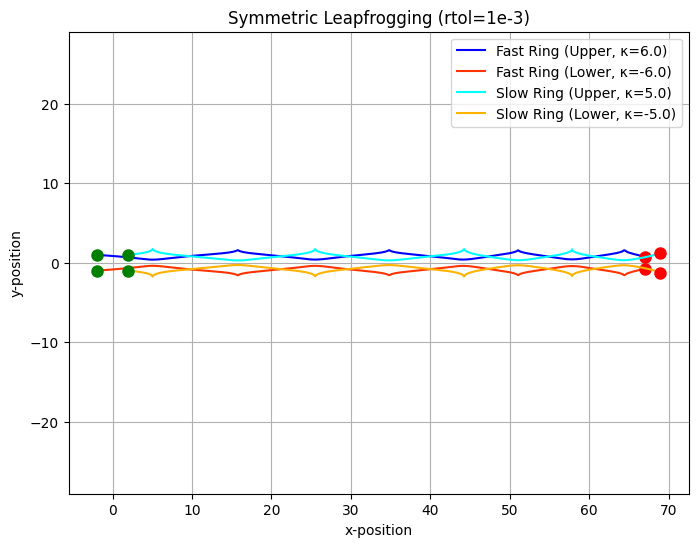

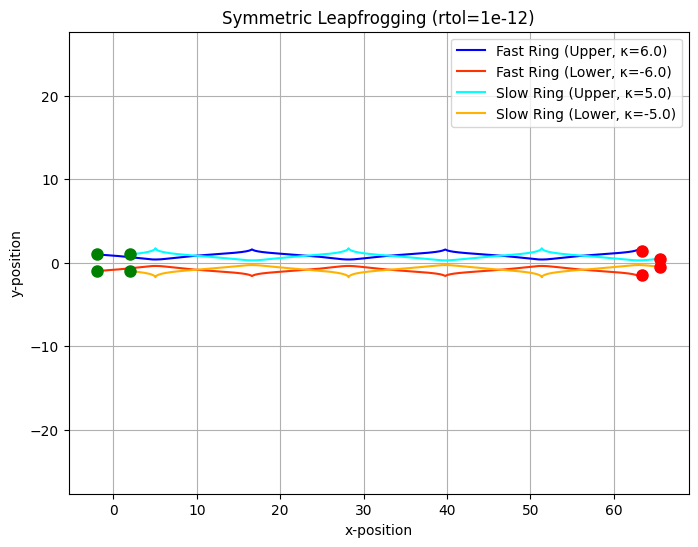

In [68]:
def plot_reconstructed_trajectories(solution, labels, title):
    '''
    Plots the full trajectories by reconstructing the lower half from the
    solution of the upper half.
    '''
    plt.figure(figsize=(8, 6))
    plt.title(title)

    num_rings = len(labels) // 2
    colors = ['blue', 'cyan']

    for i in range(num_rings):
        # Extract the trajectory of the i-th upper vortex
        upper_x_traj = solution.y[2*i, :]
        upper_y_traj = solution.y[2*i+1, :]

        # Plot the upper trajectory (from the solution)
        plt.plot(upper_x_traj, upper_y_traj, color=colors[i], label=labels[2*i])

        # Plot the lower trajectory (by enforcing symmetry)
        plt.plot(upper_x_traj, -upper_y_traj, color=plt.cm.autumn(i * 0.5 + 0.2), label=labels[2*i+1])

        # Mark start points
        plt.plot(upper_x_traj[0], upper_y_traj[0], 'go', markersize=8)
        plt.plot(upper_x_traj[0], -upper_y_traj[0], 'go', markersize=8)

        # Mark end points
        plt.plot(upper_x_traj[-1], upper_y_traj[-1], 'ro', markersize=8)
        plt.plot(upper_x_traj[-1], -upper_y_traj[-1], 'ro', markersize=8)

    plt.xlabel('x-position')
    plt.ylabel('y-position')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()

KAPPA_FAST = 6.0
KAPPA_SLOW = 5.0
WIDTH = 1.0
upper_kappa_vec = np.array([KAPPA_FAST, KAPPA_SLOW])
initial_upper_pos = np.array([[-2.0, WIDTH], [2.0, WIDTH]])
labels = [
    f'Fast Ring (Upper, κ={KAPPA_FAST})', f'Fast Ring (Lower, κ={-KAPPA_FAST})',
    f'Slow Ring (Upper, κ={KAPPA_SLOW})', f'Slow Ring (Lower, κ={-KAPPA_SLOW})'
]
t_span = (0, 100)

solution_loose = run_symmetric_simulation(initial_upper_pos, upper_kappa_vec, t_span, rtol=1e-3)
plot_reconstructed_trajectories(solution_loose, labels, 'Symmetric Leapfrogging (rtol=1e-3)')

solution_tight = run_symmetric_simulation(initial_upper_pos, upper_kappa_vec, t_span, rtol=1e-12)
plot_reconstructed_trajectories(solution_tight, labels, 'Symmetric Leapfrogging (rtol=1e-12)')

Consider three coaxial smoke rings, fired in the same direction.

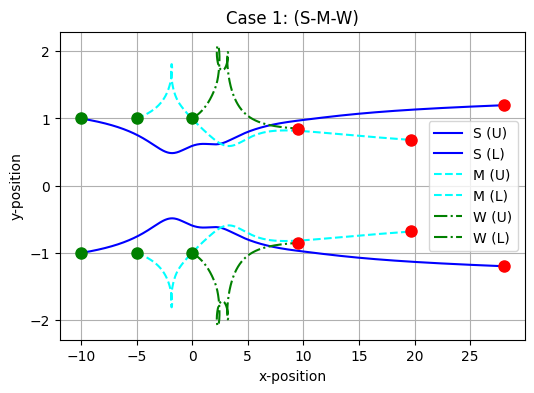

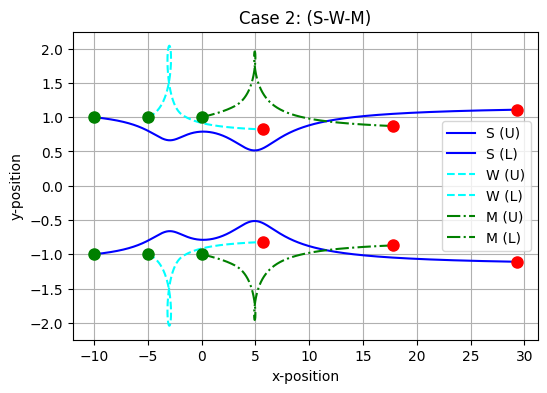

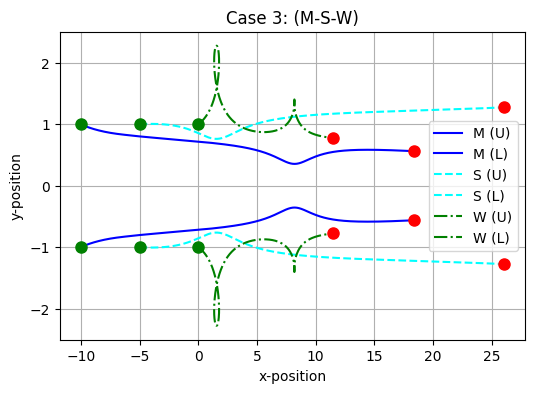

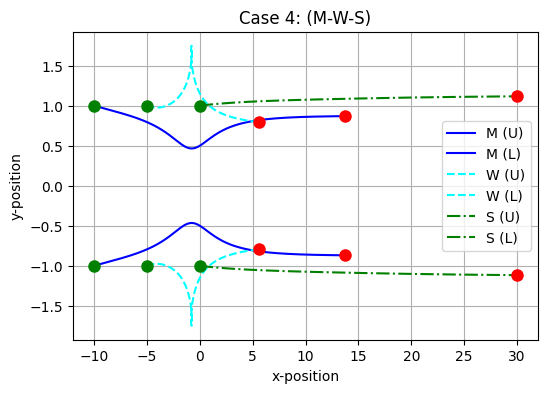

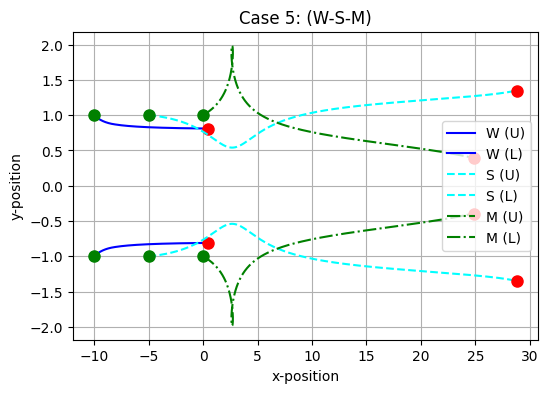

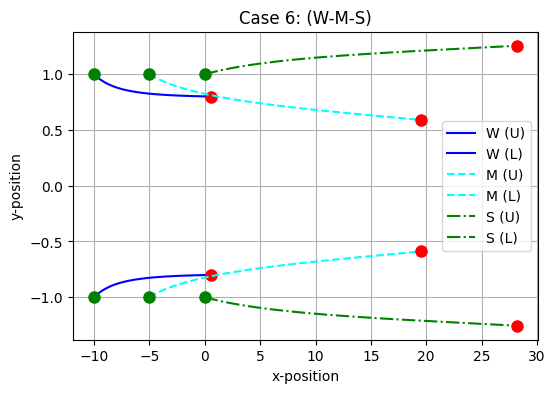

In [69]:
def plot_three_ring_trajectories(solution, labels, title):
    '''
    Plots the full trajectories for a three-ring system.
    '''
    plt.figure(figsize=(6, 4)); plt.title(title)
    colors = ['blue', 'cyan', 'green']
    line_styles = ['-', '--', '-.']
    for i in range(3):
        upper_x = solution.y[2*i, :]; upper_y = solution.y[2*i+1, :]
        plt.plot(upper_x, upper_y, color=colors[i], ls=line_styles[i], label=labels[i*2])
        plt.plot(upper_x, -upper_y, color=colors[i], ls=line_styles[i], label=labels[i*2+1])
        plt.plot(upper_x[0], upper_y[0], 'go', markersize=8)
        plt.plot(upper_x[0], -upper_y[0], 'go', markersize=8)
        plt.plot(upper_x[-1], upper_y[-1], 'ro', markersize=8)
        plt.plot(upper_x[-1], -upper_y[-1], 'ro', markersize=8)
    plt.xlabel('x-position'); plt.ylabel('y-position'); plt.grid(True)
    plt.legend(); plt.show()

WIDTH = 1.0
t_span = (0, 100)
strong = 4.0
medium = 2.0
weak = 1.0
pos = np.array([[-10.0, WIDTH], [-5.0, WIDTH], [0.0, WIDTH]])

kappa1 = np.array([strong, medium, weak])
labels1 = ['S (U)', 'S (L)', 'M (U)', 'M (L)', 'W (U)', 'W (L)']
solution1 = run_symmetric_simulation(pos, kappa1, t_span)
plot_three_ring_trajectories(solution1, labels1, 'Case 1: (S-M-W)')

kappa2 = np.array([strong, weak, medium])
labels2 = ['S (U)', 'S (L)', 'W (U)', 'W (L)', 'M (U)', 'M (L)']
solution2 = run_symmetric_simulation(pos, kappa2, t_span)
plot_three_ring_trajectories(solution2, labels2, 'Case 2: (S-W-M)')

kappa3 = np.array([medium, strong, weak])
labels3 = ['M (U)', 'M (L)', 'S (U)', 'S (L)', 'W (U)', 'W (L)']
solution3 = run_symmetric_simulation(pos, kappa3, t_span)
plot_three_ring_trajectories(solution3, labels3, 'Case 3: (M-S-W)')

kappa4 = np.array([medium, weak, strong])
labels4 = ['M (U)', 'M (L)', 'W (U)', 'W (L)', 'S (U)', 'S (L)']
solution4 = run_symmetric_simulation(pos, kappa4, t_span)
plot_three_ring_trajectories(solution4, labels4, 'Case 4: (M-W-S)')

kappa5 = np.array([weak, strong, medium])
labels5 = ['W (U)', 'W (L)', 'S (U)', 'S (L)', 'M (U)', 'M (L)']
solution5 = run_symmetric_simulation(pos, kappa5, t_span)
plot_three_ring_trajectories(solution5, labels5, 'Case 5: (W-S-M)')

kappa6 = np.array([weak, medium, strong])
labels6 = ['W (U)', 'W (L)', 'M (U)', 'M (L)', 'S (U)', 'S (L)']
solution6 = run_symmetric_simulation(pos, kappa6, t_span)
plot_three_ring_trajectories(solution6, labels6, 'Case 6: (W-M-S)')